# The Hopfield network

First we initialize the dataset (see [The MNIST dataset](http://nbviewer.ipython.org/github/francesco-mannella/neunet-basics/blob/master/course/mnist.ipynb) )


In [10]:
# download the dataset 
! wget https://raw.githubusercontent.com/sorki/python-mnist/master/get_data.sh > /dev/null 2>&1  
! bash get_data.sh >/dev/null 2>&1
! rm get_data.sh* > /dev/null 2>&1

# initialize the dataset variables
from mnist import MNIST
mndata = MNIST('./data')
mndata.load_training() # we only need the training set
img_side = 28

Now we start to build the network:

In [58]:
%matplotlib inline
from pylab import *

# the number of units of the network
n = img_side*img_side 

# we only need few samples, we take them from the training set
n_patterns = 2

# init patterns
patterns = array(mndata.train_images)[[2,5,7],]
patterns = sign(patterns/255.0 - 0.5)
patterns = patterns[:n_patterns]

Learning of the weight happens offline at the beginning, in one shot:

In [59]:
W = zeros([n,n])
for pattern in patterns :
    W += outer(pattern, pattern)
W /= float(n_patterns)
W *= (1.0 - eye(n,n))

Here is the resulting matrix of weights:

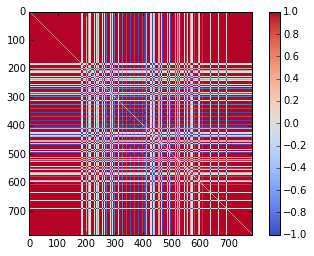

In [60]:
imshow(W,cmap=cm.coolwarm)
colorbar()
show()

In [70]:
windows = 20

def plot_img(x, fig, window, windows=windows) :
    ax = fig.add_subplot(1,windows,window)
    ax.imshow(x, interpolation='none', 
          aspect='auto', cmap=cm.gray)  
    axis('off')
    fig.canvas.draw()

def to_mat(x) :
    return x.reshape( img_side, img_side )

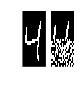

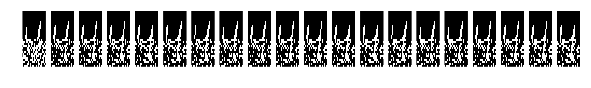

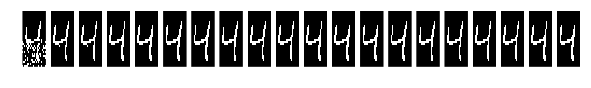

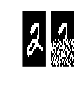

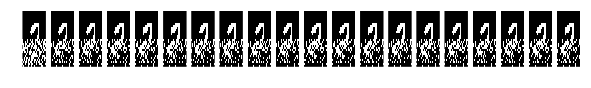

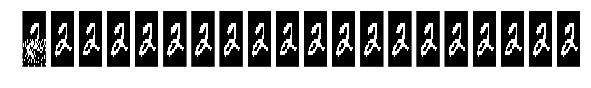

In [75]:
stime = 800

for target in [0,1] :

    x = sign(patterns[target])
    
    
    fig = figure(figsize=(10,1))        
    plot_img( to_mat(x), fig, 1 )
    
    x[(n/2):] = sign(randn(n/2))
    plot_img( to_mat(x), fig, 2 )
    
    win_count = 0
    x_indices = arange(n)
    shuffle(x_indices)
    
    for t in xrange(stime) :
        current_x = x_indices[t%n] 
        current_window = t%windows +1  
          
        x[current_x] = sign(dot(W[current_x,:],x))
                
        if win_count%20 == 0 :
            if current_window == 1 :
                fig = figure(figsize=(10,1))    
                
            plot_img( to_mat(x), fig, current_window )
            
            if current_window == windows :
                show()
        
        win_count += (t%windows == 0)
    